# C23-PR588 AUD/IDR CNN DNN RNN MODEL

Import necessary libraries

In [1]:
%run helper_functions_and_libraries.py
logging.set_verbosity(logging.ERROR)

Begin by looking at the structure of the csv that contains the data:

In [2]:
CURRENCIES_CSV = './currency_data_10_years.csv'

# Create dataframe by using datas from csv file
currencies_df = pd.read_csv(CURRENCIES_CSV)

# Create new dataframe containing ONLY needed data for the model
aud_idr_df = currencies_df[['date', 'AUD']]

# Displaying the first and last 5 row of data to understand the contents of the data
display(aud_idr_df.head())
display(aud_idr_df.tail())

,date,AUD
0,2013-05-01,9991.932116
1,2013-05-02,9976.629029
2,2013-05-03,10024.671009
3,2013-05-04,10037.051582
4,2013-05-05,9999.337595


,date,AUD
3648,2023-04-27,9743.131115
3649,2023-04-28,9706.330826
3650,2023-04-29,9696.280669
3651,2023-04-30,9699.881962
3652,2023-05-01,9719.609412


Each data point is composed of the date and the recorded exchange rate from AUD to IDR

## Parsing the raw data
Read the data from the csv file and Creating global (G) dataclass

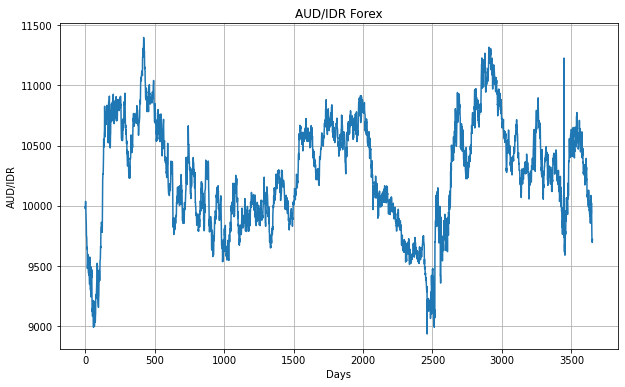

In [3]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    
    DATAFRAME = aud_idr_df
    times, values = parse_data_from_df(DATAFRAME, 'AUD')
    TIME = times
    SERIES = values
    SPLIT_TIME = 3200
    WINDOW_SIZE = 30
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES, title="AUD/IDR Forex", xlabel="Days", ylabel="AUD/IDR")

## Processing the data

train_val_split and windowed_dataset functions taken from 'tensorflow-sequences-time-series-and-prediction' courses in Coursera

In [4]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES, G.SPLIT_TIME)

In [5]:
# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

## Defining the model architecture

Using a combination of Conv1D and LSTM layers followed by Dense layers

In [6]:
def create_model():
    
    # Build the model
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
        
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, 
                               strides=1, 
                               padding="causal", 
                               activation="relu", 
                               input_shape=[None, 1]),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(32), 
        
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
        
        tf.keras.layers.Lambda(lambda x: x * 400)
    ])

    return model

In [7]:
# Test your uncompiled model
model = create_model()

# Print the model summary
model.summary()

# Check model compatibility
try:
    model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          192       
                                                                 
 lstm (LSTM)                 (None, None, 32)          8320      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 30)                990       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 1

In [8]:
# Get initial weights
init_weights = model.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

## Adjusting the learning rate

Trying optimizers:

- tf.keras.optimizers.Adam
- tf.keras.optimizers.SGD with a momentum of 0.9

In [9]:
def adjust_learning_rate(dataset, model_to_train):
    
    model = model_to_train
    
    # Set the learning rate scheduler
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
    
    # Select optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-8)
    # optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"])
    
    # Train the model
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [10]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set, model)

Epoch 1/100
100/100 [==============================] - 5s 16ms/step - loss: 10250.1133 - mae: 10250.6133 - lr: 1.0000e-08
Epoch 2/100
100/100 [==============================] - 2s 16ms/step - loss: 10250.0879 - mae: 10250.5879 - lr: 1.1220e-08
Epoch 3/100
100/100 [==============================] - 2s 16ms/step - loss: 10250.0615 - mae: 10250.5605 - lr: 1.2589e-08
Epoch 4/100
100/100 [==============================] - 2s 16ms/step - loss: 10250.0332 - mae: 10250.5332 - lr: 1.4125e-08
Epoch 5/100
100/100 [==============================] - 2s 16ms/step - loss: 10249.9990 - mae: 10250.5000 - lr: 1.5849e-08
Epoch 6/100
100/100 [==============================] - 2s 16ms/step - loss: 10249.9639 - mae: 10250.4629 - lr: 1.7783e-08
Epoch 7/100
100/100 [==============================] - 2s 16ms/step - loss: 10249.9209 - mae: 10250.4219 - lr: 1.9953e-08
Epoch 8/100
100/100 [==============================] - 2s 16ms/step - loss: 10249.8770 - mae: 10250.3770 - lr: 2.2387e-08
Epoch 9/100
100/100 [===

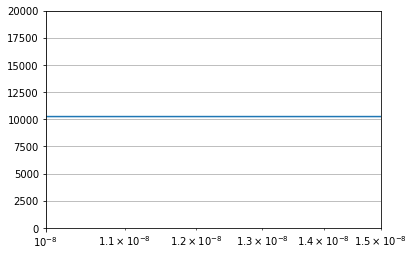

In [11]:
# Plot the loss in log scale
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])

# Set the plot boundaries
plt.axis([1e-8, 1.5e-8, 0, 20000])

# Set the grid
plt.grid(True)

In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

## Compiling the model

In [13]:
def compile_model(dataset, model_to_train):
    
    model = model_to_train

    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-8)

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    history = model.fit(dataset, epochs=100)   

    return history

In [14]:
history = compile_model(train_set, model)

Epoch 1/100
100/100 [==============================] - 5s 17ms/step - loss: 10250.1152 - mae: 10250.6162
Epoch 2/100
100/100 [==============================] - 2s 16ms/step - loss: 10250.0918 - mae: 10250.5918
Epoch 3/100
100/100 [==============================] - 2s 16ms/step - loss: 10250.0664 - mae: 10250.5674
Epoch 4/100
100/100 [==============================] - 2s 16ms/step - loss: 10250.0469 - mae: 10250.5479
Epoch 5/100
100/100 [==============================] - 2s 16ms/step - loss: 10250.0254 - mae: 10250.5264
Epoch 6/100
100/100 [==============================] - 2s 16ms/step - loss: 10250.0010 - mae: 10250.5010
Epoch 7/100
100/100 [==============================] - 2s 16ms/step - loss: 10249.9814 - mae: 10250.4814
Epoch 8/100
100/100 [==============================] - 2s 16ms/step - loss: 10249.9570 - mae: 10250.4570
Epoch 9/100
100/100 [==============================] - 2s 16ms/step - loss: 10249.9365 - mae: 10250.4355
Epoch 10/100
100/100 [==============================] -

## Visualize MAE and loss

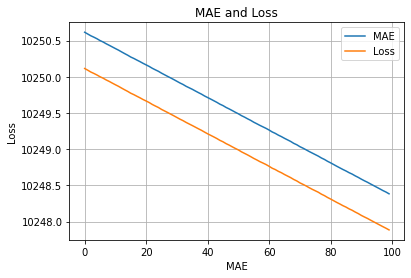

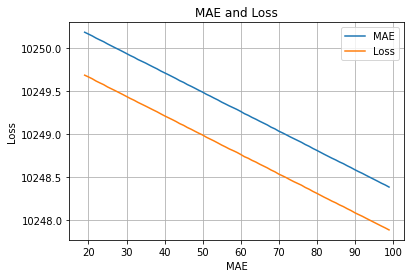

In [15]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    time=epochs, 
    series=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    time=epochs_zoom, 
    series=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Evaluating the forecast

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
15/15 [==============================] - 1s 7ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the 

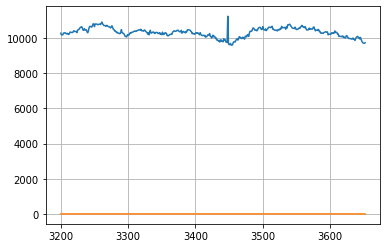

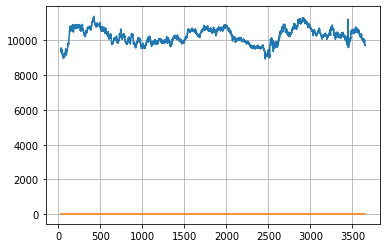

In [17]:
# Compute the forecast for all the series
rnn_forecast_valid_series = G.SERIES[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Compute the forecast for all the series
rnn_forecast_valid = model_forecast(model, rnn_forecast_valid_series, G.WINDOW_SIZE, G.BATCH_SIZE).squeeze()
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE, G.BATCH_SIZE).squeeze()

# Plot the forecast
plot_series(time_valid, (series_valid, rnn_forecast_valid))
plot_series(G.TIME[G.WINDOW_SIZE-1:], (G.SERIES[G.WINDOW_SIZE-1:], rnn_forecast))

In [18]:
compute_metrics(series_valid, rnn_forecast_valid)

{'mae': array([10250.707 , 10159.85  , 10159.849 , 10160.073 , 10261.005 ,
        10255.1   , 10276.492 , 10270.65  , 10217.542 , 10225.163 ,
        10242.786 , 10188.383 , 10185.976 , 10258.035 , 10323.779 ,
        10295.586 , 10295.668 , 10291.865 , 10302.951 , 10383.051 ,
        10381.196 , 10339.71  , 10346.388 , 10358.135 , 10288.606 ,
        10419.161 , 10461.748 , 10466.381 , 10521.341 , 10590.755 ,
        10590.511 , 10620.786 , 10546.998 , 10428.458 , 10417.135 ,
        10508.414 , 10437.26  , 10437.099 , 10444.914 , 10318.451 ,
        10275.612 , 10385.837 , 10558.894 , 10637.57  , 10637.48  ,
        10616.154 , 10596.106 , 10695.713 , 10780.633 , 10777.819 ,
        10624.746 , 10775.528 , 10769.489 , 10770.644 , 10762.881 ,
        10732.918 , 10744.856 , 10767.264 , 10767.4795, 10744.8125,
        10798.177 , 10884.286 , 10783.936 , 10740.849 , 10687.806 ,
        10687.863 , 10683.005 , 10637.124 , 10694.66  , 10689.007 ,
        10644.356 , 10612.929 , 10612.85 

In [19]:
print(f'2 last Actual Price = {series_valid[-2:]}, Predicted Price = {rnn_forecast_valid[-2:]}')

2 last Actual Price = [[9699.881962]
 [9719.609412]], Predicted Price = [11.144958 11.14407 ]


## Future Predictions

In [20]:
into_future = 100

future_forecast = make_future_forecast(values=G.SERIES,
                                       model=model,
                                       into_future=into_future,
                                       window_size=G.WINDOW_SIZE)

1/1 [==============================] - 0s 22ms/step
Predicting on:
 [[ 9991.164594]
 [10129.656911]
 [10112.958701]
 [10052.054014]
 [ 9973.110625]
 [ 9965.620727]
 [ 9968.598951]
 [ 9950.687169]
 [ 9947.506228]
 [ 9927.536872]
 [ 9940.046811]
 [ 9991.557014]
 [ 9913.167687]
 [ 9917.60924 ]
 [ 9856.107891]
 [ 9961.256773]
 [10040.224458]
 [10066.447283]
 [10085.21644 ]
 [ 9995.16504 ]
 [ 9995.165155]
 [ 9935.947873]
 [10023.99686 ]
 [ 9915.824429]
 [ 9812.169065]
 [ 9743.131115]
 [ 9706.330826]
 [ 9696.280669]
 [ 9699.881962]
 [ 9719.609412]] -> Prediction: 11.143484115600586

1/1 [==============================] - 1s 656ms/step
Predicting on:
 [10129.656911   10112.958701   10052.054014    9973.110625
  9965.620727    9968.598951    9950.687169    9947.506228
  9927.536872    9940.046811    9991.557014    9913.167687
  9917.60924     9856.107891    9961.256773   10040.224458
 10066.447283   10085.21644     9995.16504     9995.165155
  9935.947873   10023.99686     9915.824429    9812.

In [21]:
start_future = G.TIME[-1] + 1
future_time = np.arange(start_future, start_future + into_future)

# Insert last timestep/final price into next time steps and future forecasts so the plot connects
future_time = np.insert(future_time, 0, G.TIME[-1])
future_forecast = np.insert(future_forecast, 0, G.SERIES[-1])

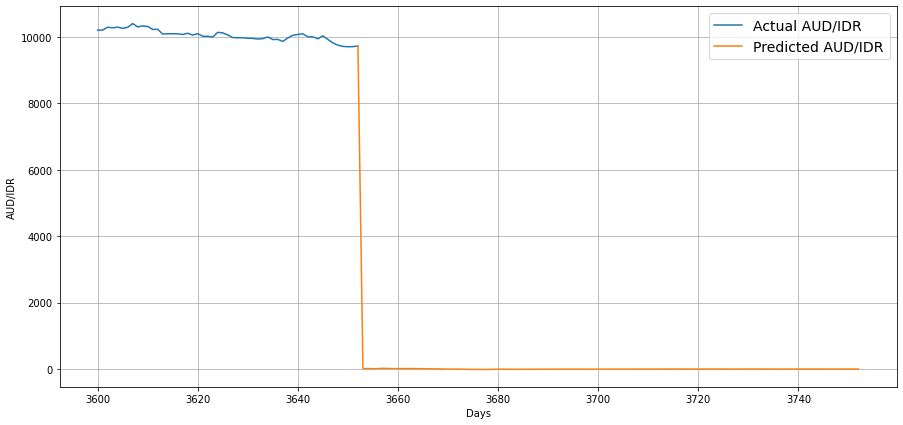

In [22]:
plt.figure(figsize=(15,7))
plot_future_forecast(G.TIME, G.SERIES, start=3600, format="-", label="Actual AUD/IDR", xlabel="Days", ylabel="AUD/IDR")
plot_future_forecast(future_time, future_forecast, format="-", label="Predicted AUD/IDR", xlabel="Days", ylabel="AUD/IDR")

### Model is unstable and mostly underfitted, the MAE is over 10000 which make this model a bad model